# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:

```sh
!pip uninstall gym -y
!pip install gym
```
<br>

And here is gymnasium version:

```python
gymnasium.__version__
```
1.2.0

In [ ]:
# !pip install -U gym==0.25.2
!pip install swig
!pip install gymnasium[atari]
!pip install gymnasium[box2d]
!pip install gymnasium[accept-rom-license]
# !pip install autorom[accept-rom-license]

In [40]:
import gymnasium
gymnasium.__version__

'1.2.0'

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics
import torch
import os

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
def display_video(episode=0, video_width=600):
    """
    Displays a video from a specified episode with customizable width.

    Args:
        episode (int): The episode number to load the video for. Defaults to 0.
        video_width (int): The width of the video player in pixels. Defaults to 600.

    Returns:
        IPython.display.HTML: An HTML video element that can be rendered in Jupyter notebooks.

    Note:
        - The function expects video files to be in './video/' directory with naming format 'rl-video-episode-{N}.mp4'
        - Videos are base64 encoded and embedded directly in the HTML for display
    """
    # Construct the path to the video file based on episode number
    video_path = f"./video/rl-video-episode-{episode}.mp4"

    # Read the video file as binary data
    video_file = open(video_path, "rb").read()

    # Encode the binary video data as base64 string
    decoded = b64encode(video_file).decode()

    # Create a data URL for the video
    video_url = f"data:video/mp4;base64,{decoded}"

    # Return an HTML video element with the embedded video
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode="rgb_array", record=False, eps_record=50, video_folder='./video'):
    """
    Creates and configures a Gym environment with optional video recording and statistics tracking.

    Args:
        name (str): Name of the Gym environment to create (e.g., 'CartPole-v1')
        render_mode (str): Rendering mode - "human", "rgb_array", or "ansi". Defaults to "rgb_array"
        record (bool): Whether to record videos of the environment. Defaults to False
        eps_record (int): Record a video every N episodes (when record=True). Defaults to 50
        video_folder (str): Directory to save recorded videos. Defaults to './video'

    Returns:
        gym.Env: Configured Gym environment wrapped with recording and statistics tracking

    Note:
        - When record=True, videos will be saved in the specified folder with automatic naming
        - The environment is always wrapped with episode statistics tracking
    """
    # Create base Gym environment with specified render mode
    env = gym.make(name, render_mode=render_mode)

    # Optionally wrap environment with video recorder
    if record:
        # Record video every eps_record episodes (trigger function)
        env = RecordVideo(env, video_folder=video_folder,
                         episode_trigger=lambda x: x % eps_record == 0)

    # Always wrap environment with episode statistics tracker
    env = RecordEpisodeStatistics(env)

    return env

def show_reward(total_rewards):
    """
    Plots the progression of rewards across episodes using matplotlib.

    Args:
        total_rewards (list or array-like): A sequence of reward values obtained per episode.

    Displays:
        A line plot showing the reward trend over episodes with:
        - X-axis: Episode number
        - Y-axis: Reward value

    Note:
        - This function immediately displays the plot using plt.show()
        - The plot uses default matplotlib styling
        - Useful for visualizing training progress in reinforcement learning
    """
    # Create line plot of reward values
    plt.plot(total_rewards)

    # Label the x-axis as 'Episode'
    plt.xlabel('Episode')

    # Label the y-axis as 'Reward'
    plt.ylabel('Reward')

    # Display the plot
    plt.show()

## What Is a **Policy** in Reinforcement Learning?
A policy is a strategy that an agent uses in pursuit of goals. The policy dictates the actions that the agent takes as a function of the agent's state and the environment.

<br>

1. **Deterministic Policy**

In a deterministic policy, there is only one particular action possible in a given state. When the agent reaches a given state, the deterministic policy tells it to perform a particular action always.

- At any given time $t$, for a given state $s$, the deterministic policy $μ$ tells the agent to perform an action $a$. It can be expressed as:

<h1><center> $μ(s) = a$</center></h1>

2. **Stochastic Policy**

In stochastic policy, it returns a probability distribution of multiple actions in the action space for a given state. It is in contrast with the deterministic policy which always mapped a given state to only one particular action. So in this scenario, the agent may perform different actions each time it visits a particular state based on the probability distribution of actions returned by the stochastic policy.

- At any given time $t$, for a given state $s$, the deterministic policy $μ$ tells the agent to perform an action $a$ with a certain probability.

<h1><center> $μ(a|s)$</center></h1>

**Type of stochastic Policy:**
1. **Categorical Policy**: select the actions from the discrete action space.
2. **Gussian Policy**: action space is continuous.

## Implementing **random search policy**

It's simple but effective approach to map an observation to a vector which represent actions, the action with higher value will be picked.

- The linear mapping is depicted by a **Weight matrix** whose size is `observation_number * action_number`.
- the weight is randomly generated and is used to compute action for each step.

In [22]:
def run_episode(env, weight):
    """
    Runs a single episode in the environment using linear policy weights to select actions.

    Args:
        env (gym.Env): The environment to run the episode in
        weight (torch.Tensor): The weight matrix for the linear policy (state -> action)

    Returns:
        float: The total reward accumulated during the episode

    Note:
        - Uses a deterministic linear policy (state multiplied by weights)
        - Always selects the action with highest Q-value (argmax)
        - Converts states to PyTorch tensors automatically
        - Handles environment reset and tracks episode termination
    """
    # Initialize the environment and get starting state
    state, _ = env.reset()

    # Initialize reward counter
    total_reward = 0

    # Initialize episode termination flag
    done = False

    # Main episode loop
    while not done:
        # Convert numpy state to PyTorch tensor
        state = torch.from_numpy(state).float()

        # Compute action using linear policy (matrix multiplication + argmax)
        action = torch.argmax(torch.matmul(state, weight))

        # Take action in environment, get next state and reward
        state, reward, done, info = env.step(action.item())

        # Accumulate reward
        total_reward += reward

    # Return total reward obtained in this episode
    return total_reward

In [24]:
# Remove existing video directory and contents (if any)
!rm -r ./video

# Create CartPole environment with recording enabled
# - Records every 20 episodes
# - Uses rgb_array render mode for video capture
env = create_env("CartPole-v1", 'rgb_array', record=True, eps_record=20)

# Get environment dimensions
n_state = env.observation_space.shape[0]  # Number of state features
n_action = env.action_space.n  # Number of possible actions

# Initialize training variables
total_rewards = []  # Stores reward for each episode
n_episodes = 100  # Total number of training episodes
best_total_reward = 0  # Tracks highest reward achieved
best_wieght = None  # Stores weights that achieved best reward

# Main training loop
for episode in range(n_episodes):
    # Initialize random policy weights (linear mapping from states to action values)
    weight = torch.rand((n_state, n_action))

    # Run one episode with current weights
    total_reward = run_episode(env, weight)

    # Store this episode's reward
    total_rewards.append(total_reward)

    # Update best weights if current episode performed better
    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight

Episode 0 total reward: 35.0
Episode 3 total reward: 55.0
Episode 5 total reward: 500.0


In [27]:
avg_tot_reward = sum(total_rewards) / n_episodes
print(f"Average total reward over {n_episodes} episodes: {avg_tot_reward}")

Average total reward over 100 episodes: 61.82


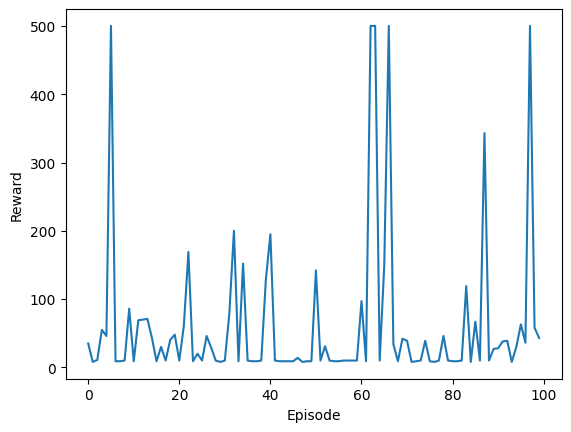

In [28]:
show_reward(total_rewards)

In [32]:
# Now run on best weight
!rm -r ./video
env = create_env("CartPole-v1", 'rgb_array', record = True, eps_record = 10)
total_rewards = []
n_episodes = 100
weight = best_wieght

for episode in range(n_episodes):
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight

avg_tot_reward = sum(total_rewards) / n_episodes
print(f"Average total reward over {n_episodes} episodes: {avg_tot_reward}")

Average total reward over 100 episodes: 420.35


In [33]:
display_video(90)

### Developing **the hill climbing algorithm**
As we can see in the random searc policy each episode is independent. and eventually the weight with the best performance will be selected.

a hill-climbing algorithm, transfer the knowledge acquired in one episode to the next episode

we also start with a randomly chosen weight. But here, for every episode we add some noise the weight, If the total reward improves we update the weight with the new one, otherwise, we keep the old one

In [ ]:
# Clean up previous video recordings
!rm -r ./video

# Create CartPole environment with video recording enabled
env = create_env("CartPole-v1", 'rgb_array', record=True, eps_record=20)

n_state = env.observation_space.shape[0]  # Number of state features (4 for CartPole)
n_action = env.action_space.n  # Number of possible actions (2 for CartPole)

# Initialize training variables
total_rewards = []  # Track rewards for each episode
n_episodes = 100  # Number of episodes to run
noise_scale = 0.01  # Controls exploration magnitude (small perturbations)

# Refinement training loop - builds on previous best weights
for episode in range(n_episodes):
    # Adds small random noise to encourage exploration around good solutions
    weight = best_wieght + noise_scale * torch.rand((n_state, n_action))

    # Evaluate current weights
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    # Update best weights if improved performance found
    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight  # Update new best weights

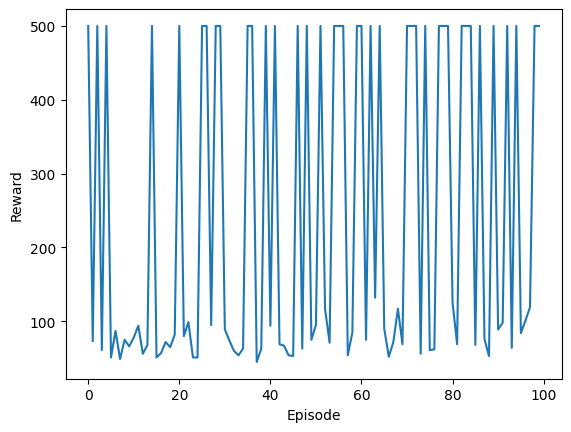

In [ ]:
show_reward(total_rewards)

#### **make noise adaptive**
1. specify a starting noise
2. if the performance improves, decrease the noise scale. otherwise increase the noise scale

In [37]:
# use best_weight from previous run
!rm -r /content/video
env = create_env("CartPole-v1", 'rgb_array', record=True, eps_record=20)

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
total_rewards = []
best_total_reward = 0
n_episodes = 100
noise_scale = 0.01
# start with a random weight
best_wieght = torch.rand((n_state, n_action))

for episode in range(n_episodes):
    weight = best_wieght + noise_scale * torch.rand((n_state, n_action))
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight
        noise_scale = max(noise_scale / 2, 1e-4)
    else:
        noise_scale = min(noise_scale * 2, 2)

Episode 0 total reward: 247.0
Episode 2 total reward: 421.0
Episode 14 total reward: 500.0


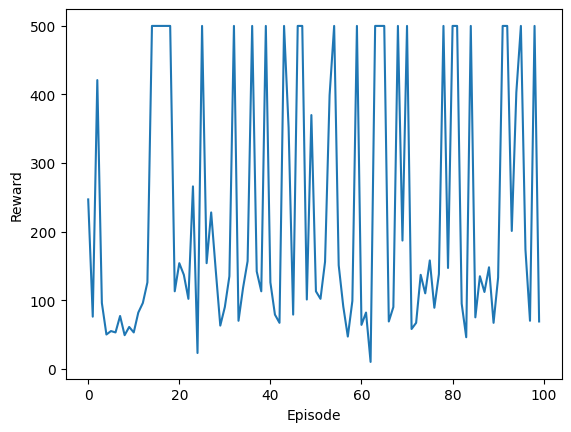

In [38]:
show_reward(total_rewards)